In [1]:
import tensorflow as tf
import utilities as ut
import importlib
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input, Conv3D, MaxPool3D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from gen import FrameGenerator
import os
from keras.layers import Lambda, Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
import pandas as pd
import cv2 
import numpy as np

## Create Network 

In [2]:
Input_Layer = Input(shape=(32,224,224,5),name='Input Layer') 
#RGB Stream
RGB_Layer1 = Lambda(lambda x: x[:,:,:,:,:3])(Input_Layer)
RGB_Layer2 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer1)
RGB_Layer3 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer2)
RGB_Layer4 = MaxPool3D((1,2,2))(RGB_Layer3)
RGB_Layer5 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer4)
RGB_Layer6 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer5)
RGB_Layer7 = MaxPool3D((1,2,2))(RGB_Layer6)

RGB_Layer8 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer7)
RGB_Layer9 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer8)
RGB_Layer10 = MaxPool3D((1,2,2))(RGB_Layer9)
RGB_Layer11 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer10)
RGB_Layer12 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(RGB_Layer11)
RGB_Layer13 = MaxPool3D((1,2,2))(RGB_Layer12)

#Optical Flow Stream
Flow_Layer1 = Lambda(lambda x: x[:,:,:,:,3:5])(Input_Layer)
Flow_Layer2 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer1)
Flow_Layer3 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer2)
Flow_Layer4 = MaxPool3D((1,2,2))(Flow_Layer3)
Flow_Layer5 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer4)
Flow_Layer6 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer5)
Flow_Layer7 = MaxPool3D((1,2,2))(Flow_Layer6)

Flow_Layer8 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer7)
Flow_Layer9 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Flow_Layer8)
Flow_Layer10 = MaxPool3D((1,2,2))(Flow_Layer9)
Flow_Layer11 = Conv3D(filters=32, kernel_size=(1,3,3),activation='sigmoid',padding='same',kernel_initializer='variance_scaling')(Flow_Layer10)
Flow_Layer12 = Conv3D(filters=32, kernel_size=(3,1,1),activation='sigmoid',padding='same',kernel_initializer='variance_scaling')(Flow_Layer11)
Flow_Layer13 = MaxPool3D((1,2,2))(Flow_Layer12)


#Fusion and Pooling
Fusion_Layer = Multiply()([RGB_Layer13,Flow_Layer13])
Pool = MaxPool3D((8,1,1))(Fusion_Layer)

#Merging Block
Merge_Layer_2 = Conv3D(filters=64, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Pool)
Merge_Layer_3 = Conv3D(filters=64, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Merge_Layer_2)
Merge_Layer_4 = MaxPool3D((2,2,2))(Merge_Layer_3)

Merge_Layer_5 = Conv3D(filters=64, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Merge_Layer_4)
Merge_Layer_6 = Conv3D(filters=64, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Merge_Layer_5)
Merge_Layer_7 = MaxPool3D((2,2,2))(Merge_Layer_6)

Merge_Layer_2_2 = Conv3D(filters=128, kernel_size=(1,3,3),activation='relu',padding='same',kernel_initializer='variance_scaling')(Merge_Layer_7)
Merge_Layer_2_3 = Conv3D(filters=128, kernel_size=(3,1,1),activation='relu',padding='same',kernel_initializer='variance_scaling')(Merge_Layer_2_2)
Merge_Layer_2_4 = MaxPool3D((1,2,2))(Merge_Layer_2_3)


#Fully Connected Layers
FC_1 = Flatten()(Merge_Layer_2_4)
FC_2 = Dense(128,activation='relu')(FC_1)
FC_3 = Dropout(0.2)(FC_2)
FC_4 = Dense(32,activation='relu')(FC_3)

output = Dense(2,activation='softmax')(FC_4)

model = Model(inputs=Input_Layer,outputs=output)

## Plot model

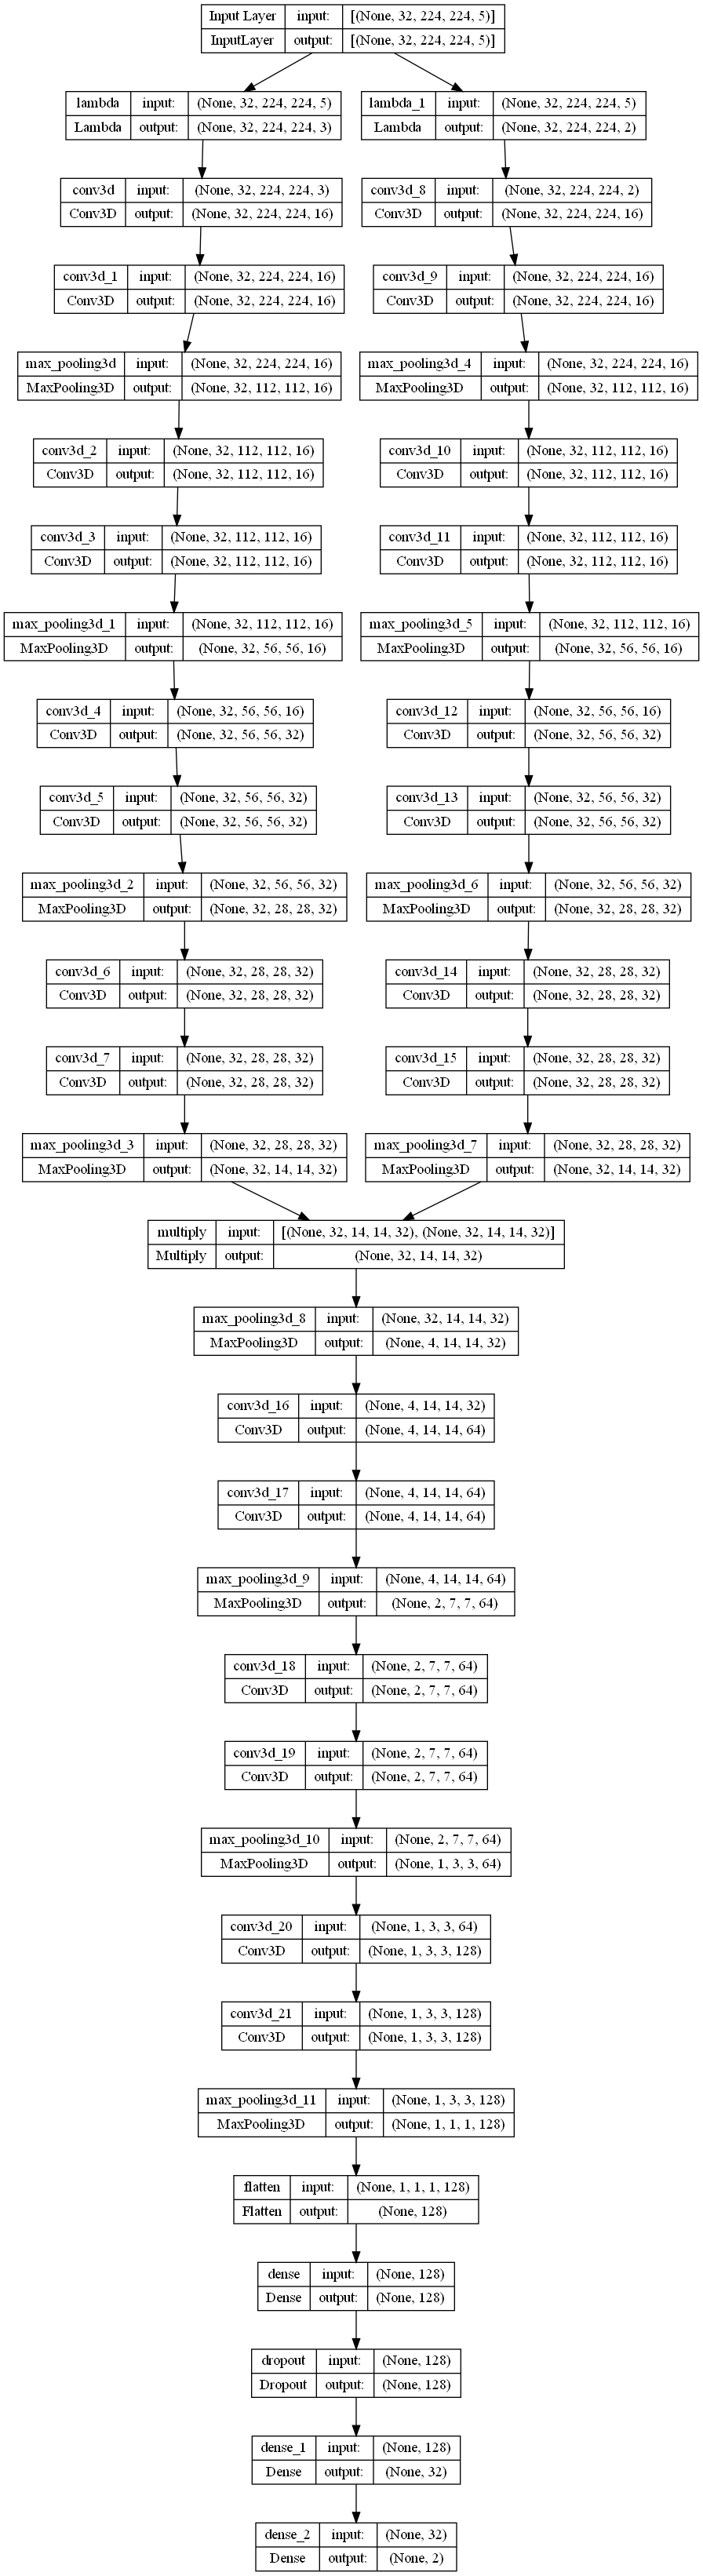

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## Breaking Videos into Frames and <br>Creating CSV of each Batch for faster generator

In [ ]:
import utilities as ut
RWF = ut.Preprocess('RWF-2000')
RWF.dataframe(16,'Flows',seq_length=80,num_threads=100,toSequence=True,toDelete=True,createCSV=True,target_size=(224,224))

Creating Directories: 100%|██████████| 3/3 [00:00<00:00, 2978.91it/s]


Discovered 2000 Videos


Creating CSV: 100%|██████████| 158000/158000 [00:07<00:00, 22465.53it/s]


## Creating generator

In [3]:
batch_size = 2
STRIDE = 4
SEQUENCE_LENGTH = 32
SIZE=(224,224)

In [4]:
from gen import FrameGenerator

In [5]:
path = os.path.join("RWF-2000 Flows","data_files")
params = {
    'batch_size':batch_size,
    'target_size':SIZE,
    'temporal_stride': STRIDE,
    'append_flows': True,
    'temporal_length': SEQUENCE_LENGTH,
    'n_classes':2, 
    'is_autoencoder':False,
    'shuffle':True }
train_gen = FrameGenerator(path,**params)
params = {
    'temporal_stride': STRIDE,
    'temporal_length': SEQUENCE_LENGTH,
    'append_flows': True,
    'label': 'val',
    'target_size':SIZE,
    'n_classes':2, 
    'is_autoencoder':False,
    'shuffle':False }
    
valid_gen = FrameGenerator(path,**params)

Found 19200 videos belonging to 2 classes.
Found 4800 videos belonging to 2 classes.


## Compiling and fitting model in generator

In [6]:
model.compile(loss='categorical_crossentropy', optimizer= optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])

c:\Users\tdiam\miniconda3\envs\tf2.4\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('Two-Stream.ckpt'),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

In [8]:
history = model.fit(train_gen,batch_size=batch_size,validation_data=valid_gen,callbacks = callbacks,epochs=20,verbose=1)

Epoch 1/20
9600/9600 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.5006

ValueError: Got non-flat/non-unique argument names for SavedModel signature 'serving_default': more than one argument to '__inference_signature_wrapper_62673' was named 'Input Layer'. Signatures have one Tensor per named input, so to have predictable names Python functions used to generate these signatures should avoid *args and Tensors in nested structures unless unique names are specified for each. Use tf.TensorSpec(..., name=...) to provide a name for a Tensor input.